# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/depi/EuroSAT_RGB.zip" -d "/content/eurosat"
!ls -la /content/eurosat

total 12
drwxr-xr-x  3 root root 4096 Nov 29 19:15 .
drwxr-xr-x  1 root root 4096 Nov 29 19:15 ..
drwxr-xr-x 12 root root 4096 Mar  9  2023 EuroSAT_RGB


# Data Pipeline

In [ ]:
import tensorflow as tf
import pathlib
from tensorflow.keras import layers

DATA_DIR = "/content/eurosat/EuroSAT_RGB"
img_size = (128, 128)
seed =  42
batch_size = 32

data_root = pathlib.Path(DATA_DIR)
all_image_paths = list(data_root.glob('*/*.jpg'))
print("Total images:", len(all_image_paths))

Total images: 27000


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.3,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 27000 files belonging to 10 classes.
Using 18900 files for training.
Found 27000 files belonging to 10 classes.
Using 8100 files for validation.
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1)
])

# Model Building

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB0, efficientnet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## Grid Search

In [ ]:
def build_model(dropout_rate=0.4, lr=1e-3):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(*img_size, 3)
    )
    base_model.trainable = False

    inputs = Input(shape=(*img_size, 3))
    x = data_augmentation(inputs)
    x = efficientnet.preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

param_grid = [
    {'lr': 1e-3, 'dropout': 0.3},
    {'lr': 5e-4, 'dropout': 0.4},
    {'lr': 1e-4, 'dropout': 0.5},
]

results = []
for params in param_grid:
    print("Testing params:", params)
    temp_model = build_model(dropout_rate=params['dropout'], lr=params['lr'])
    hist = temp_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=4,
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
        verbose=1
    )
    best_val_acc = max(hist.history['val_accuracy'])
    results.append((params, best_val_acc))

print("Grid search results:")
for params, acc in results:
    print(params, " -> best val acc:", acc)

Testing params: {'lr': 0.001, 'dropout': 0.3}
Epoch 1/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.7283 - loss: 0.8913 - val_accuracy: 0.9129 - val_loss: 0.2591
Epoch 2/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.8951 - loss: 0.3260 - val_accuracy: 0.9267 - val_loss: 0.2157
Epoch 3/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9028 - loss: 0.2876 - val_accuracy: 0.9351 - val_loss: 0.1936
Epoch 4/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.9176 - loss: 0.2600 - val_accuracy: 0.9347 - val_loss: 0.1815
Testing params: {'lr': 0.0005, 'dropout': 0.4}
Epoch 1/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.6395 - loss: 1.1804 - val_accuracy: 0.8960 - val_loss: 0.3464
Epoch 2/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.8755 - loss: 0.4118 - val_accuracy: 0.9129 - val_loss: 0.2660
Epoch 3/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.8857 - loss: 0.3494 - val_accuracy: 0.9203 - val_loss: 0.2269
Epoc

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
inputs = Input(shape=(*img_size, 3))
x = data_augmentation(inputs)
x = efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Model Fine-tuning

In [ ]:
checkpoint_path = "/content/drive/MyDrive/depi/models/eurosat_effb0_best.keras"

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
initial_epochs = 8

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=callbacks
)

Epoch 1/8
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7170 - loss: 0.9119 - precision: 0.8963 - recall: 0.5232
Epoch 1: val_accuracy improved from -inf to 0.91436, saving model to /content/drive/MyDrive/depi/models/eurosat_effb0_best.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.7174 - loss: 0.9108 - precision: 0.8964 - recall: 0.5238 - val_accuracy: 0.9144 - val_loss: 0.2603 - val_precision: 0.9361 - val_recall: 0.8847 - learning_rate: 0.0010
Epoch 2/8
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8874 - loss: 0.3466 - precision: 0.9166 - recall: 0.8534
Epoch 2: val_accuracy improved from 0.91436 to 0.92277, saving model to /content/drive/MyDrive/depi/models/eurosat_effb0_best.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8874 - loss: 0.3465 - precision: 0.9166 - recall: 0.8534 - val_accuracy: 0.9228 - val_loss: 0.2212 - val_precision: 0.9374 - val_recall: 0.9045 - learning_rate: 0.0010
Epoch 3/8
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:220]:
  layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs


history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks
)

Epoch 9/18
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7916 - loss: 0.6771 - precision: 0.8311 - recall: 0.7528
Epoch 9: val_accuracy did not improve from 0.94208
591/591 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.7917 - loss: 0.6769 - precision: 0.8312 - recall: 0.7528 - val_accuracy: 0.9020 - val_loss: 0.2972 - val_precision: 0.9173 - val_recall: 0.8787 - learning_rate: 1.0000e-05
Epoch 10/18
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8478 - loss: 0.4767 - precision: 0.8797 - recall: 0.8228
Epoch 10: val_accuracy did not improve from 0.94208
591/591 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.8478 - loss: 0.4767 - precision: 0.8797 - recall: 0.8228 - val_accuracy: 0.9129 - val_loss: 0.2548 - val_precision: 0.9239 - val_recall: 0.9015 - learning_rate: 1.0000e-05
Epoch 11/18
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8721 - loss: 0.4073 - precision: 0.8944 - recall: 0.8504
Epoch 11: val_accuracy did not improve from 0.94208
591/591 ━━━━━

# Model Evaluation

In [ ]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision (macro-ish): {test_prec:.4f}")
print(f"Test Recall (macro-ish): {test_rec:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9504 - loss: 0.1550 - precision: 0.9575 - recall: 0.9431
Test Loss: 0.1623
Test Accuracy: 0.9444
Test Precision (macro-ish): 0.9527
Test Recall (macro-ish): 0.9385


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [ ]:
macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

Macro F1-score: 0.9423
Weighted F1-score: 0.9445


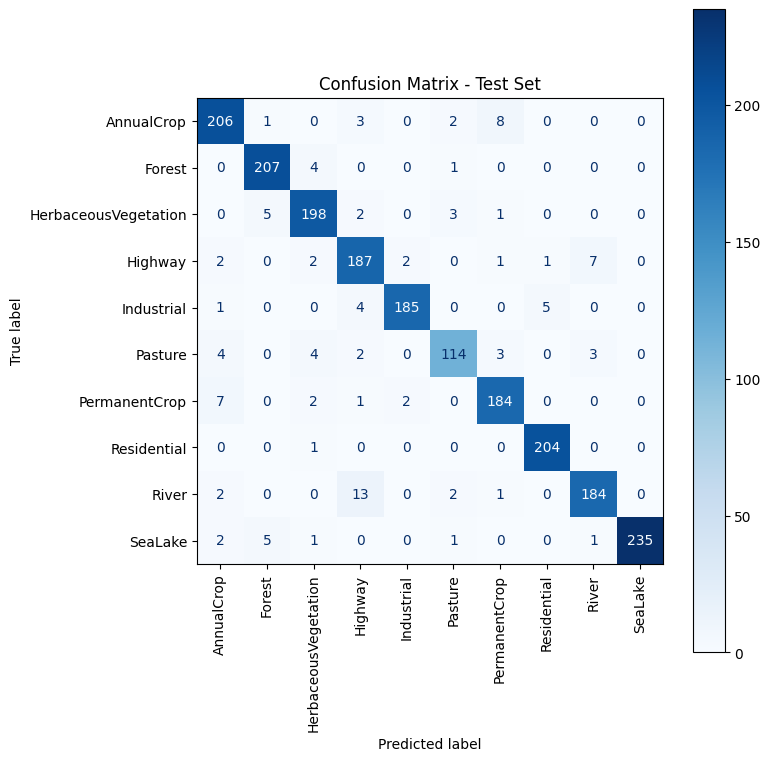

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

In [ ]:
print("Classification report (per class):")
print(classification_report(y_true, y_pred, target_names=class_names))

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls_name, acc in zip(class_names, per_class_acc):
    print(f"Accuracy for {cls_name}: {acc:.4f}")

Classification report (per class):
                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.94      0.93       220
              Forest       0.95      0.98      0.96       212
HerbaceousVegetation       0.93      0.95      0.94       209
             Highway       0.88      0.93      0.90       202
          Industrial       0.98      0.95      0.96       195
             Pasture       0.93      0.88      0.90       130
       PermanentCrop       0.93      0.94      0.93       196
         Residential       0.97      1.00      0.98       205
               River       0.94      0.91      0.93       202
             SeaLake       1.00      0.96      0.98       245

            accuracy                           0.94      2016
           macro avg       0.94      0.94      0.94      2016
        weighted avg       0.95      0.94      0.94      2016

Accuracy for AnnualCrop: 0.9364
Accuracy for Forest: 0.9764
Accuracy for HerbaceousVegetation:

# Model Saving

In [ ]:
model.save('/content/drive/MyDrive/depi/models/eurosat_effb0_final.keras')